In [23]:
import torch
import numpy as np
from glob import glob
import cv2                
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.nn.functional as F
from IPython.core.debugger import set_trace
%matplotlib inline                               
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [38]:
transform = transforms.Compose([transforms.CenterCrop(224),
                                transforms.ToTensor(),
                               transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
train_data = datasets.ImageFolder('../data/train/', transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=96, shuffle=True)

valid_data = datasets.ImageFolder('../data/valid/', transform=transform)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=96, shuffle=True)

test_data = datasets.ImageFolder('../data/test/', transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=96, shuffle=True)
# specify the image classes
classes = ['Melanoma','Nevi','Seborrheic Keratoses']

In [25]:
# # helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

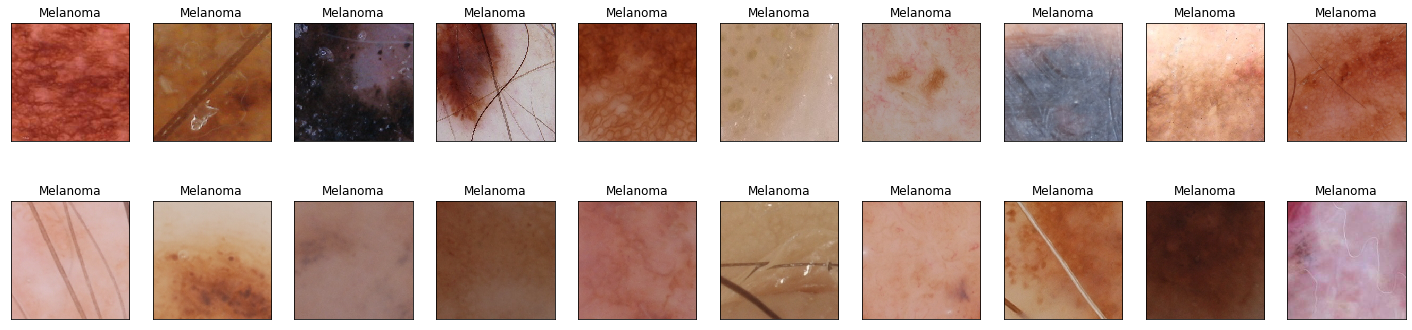

In [26]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() 
fig = plt.figure(figsize=(25, 6))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [27]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(1024*7*7, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 3)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 1024*7*7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net().to(device)

In [28]:
model_scratch

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [29]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

In [40]:
# # the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, train_loader, valid_loader, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf # track change in validation loss
    train_loss = 0.0
    valid_loss = 0.0
    for epoch in range(1, n_epochs+1):

        # keep track of training and validation loss
        
        ###################
        # train the model #
        ###################
        model.train()
        for images, labels in train_loader:
            # move tensors to GPU if CUDA is available
            if use_cuda:
                images, labels = images.cuda(), labels.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(images)
            # calculate the batch loss
            loss = criterion(output, labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*images.size(0)

        ######################    
        # validate the model #
        ######################
        model.eval()
        for images, labels in valid_loader:
            # move tensors to GPU if CUDA is available
            if use_cuda:
                images, labels = images.cuda(), labels.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(images)
            # calculate the batch loss
            loss = criterion(output, labels)
            # update average validation loss 
            valid_loss += loss.item()*images.size(0)

        # calculate average losses
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)

        # print training/validation statistics 
        print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
        # save model if validation loss has decreased
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print(f'validation loss decreased from: {valid_loss_min} ----> {valid_loss}.......Saving Model....')
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    # return trained model
    return model

In [41]:
# train the model
model_scratch = train(10,train_loader,valid_loader,model_scratch,optimizer_scratch,criterion_scratch,use_cuda,'model_scratch.pt')

Epoch: 1 	Training Loss: 0.000000 	Validation Loss: 0.000000
validation loss decreased from: inf ----> 0.0.......Saving Model....
Epoch: 2 	Training Loss: 0.000000 	Validation Loss: 0.000000
Epoch: 3 	Training Loss: 0.000000 	Validation Loss: 0.000000


KeyboardInterrupt: 

In [42]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

<All keys matched successfully>

In [43]:
def test(test_loader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [44]:
# call test function    
test(test_loader, model_scratch, criterion_scratch, use_cuda)

Test Loss: 0.000000


Test Accuracy: 100% (600/600)


In [45]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.densenet161(pretrained=True)
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
model_transfer.classifier = nn.Linear(2208, len(train_data.classes))

if use_cuda:
    model_transfer = model_transfer.cuda()
model_transfer.classifier

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /home/jupyter/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 216MB/s] 


Linear(in_features=2208, out_features=1, bias=True)

In [47]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.001)

In [ ]:
# train the model
model_transfer = train(2, train_loader,valid_loader, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')